# Stock Volatility Prediction

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import numpy as np
from sklearn.linear_model import Lasso
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the dataset
data = pd.read_csv("stock_volatility_labeled.csv")

# Convert Date to datetime and sort by date
data['Date'] = pd.to_datetime(data['Date'])

rmse_results = {}


----

## Introduction

Stock market volatility is a critical indicator of risk and uncertainty in financial markets, influencing investment decisions, portfolio management, and economic policy. Accurately predicting stock volatility enables investors and financial professionals to assess and manage risk more effectively, optimize trading strategies, and improve decision-making processes. This report focuses on predicting monthly stock volatility using historical market data and financial indicators. By applying data analysis, feature engineering, and machine learning techniques, we aim to develop robust regression models that forecast volatility, offering valuable insights for managing financial risk.

----

## Exploratory Data Analysis


In [2]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price',
       'Return', 'Volatility', 'Revenue', 'Net Income', 'Gross Profit', 'EPS',
       'Total Assets', 'Total Liabilities', 'Total Equity',
       'Cash and Cash Equivalents', 'Operating Cash Flow',
       'Investing Cash Flow', 'Financing Cash Flow', 'Stock'],
      dtype='object')

In [3]:
data.isna().sum()

Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Amount                       0
Avg_Price                    0
Return                       0
Volatility                   0
Revenue                      0
Net Income                   0
Gross Profit                 0
EPS                          0
Total Assets                 0
Total Liabilities            0
Total Equity                 0
Cash and Cash Equivalents    0
Operating Cash Flow          0
Investing Cash Flow          0
Financing Cash Flow          0
Stock                        0
dtype: int64

The dataset contains 22 months of stock information from January, 2022 to October 2023. The dataset is already clean, have no missing value.

### Handling Outliers

Text(0.5, 1.0, 'Boxplot of All Features')

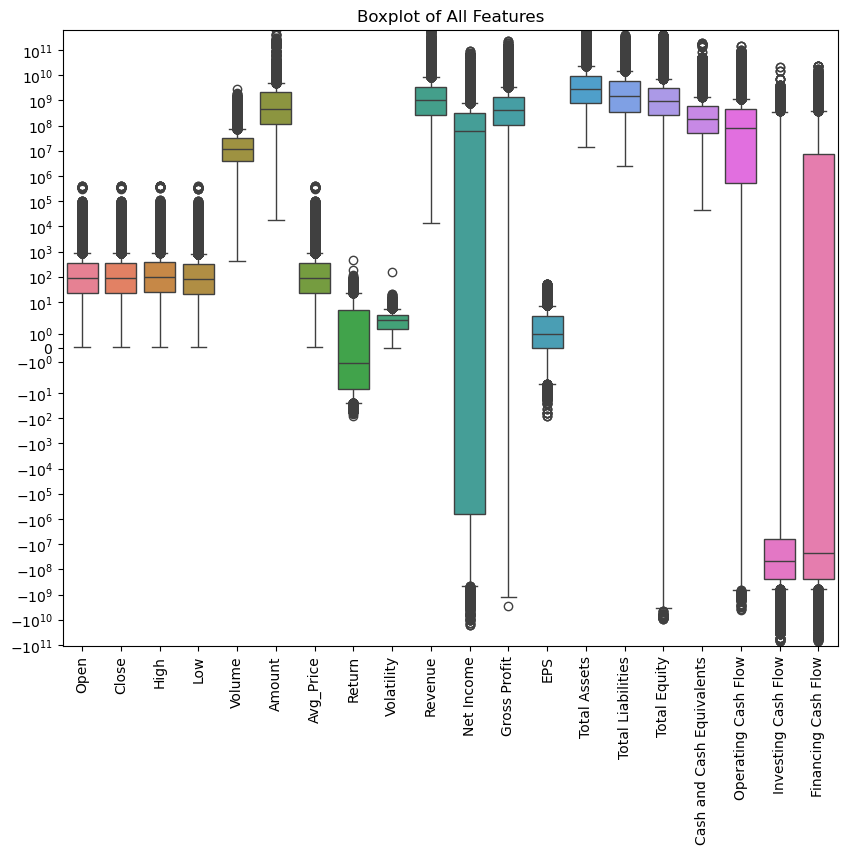

In [75]:
# Boxplot for outlier detection in key features
plt.figure(figsize=(10, 8))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.yscale('symlog')
plt.title('Boxplot of All Features')

The boxplot shows significant outliers across various features. High variability in Return and Volatility suggests that some stocks experience exceptional gains, losses, or volatility spikes. Outliers can affect model performance, and using <b>RobustScaler</b> can help standardize these features.

To address the impact of these outliers, applied RobustScaler, which scales features using the median and the interquartile range, making it more robust to outliers compared to standard scaling methods.

## Correlation Analysis

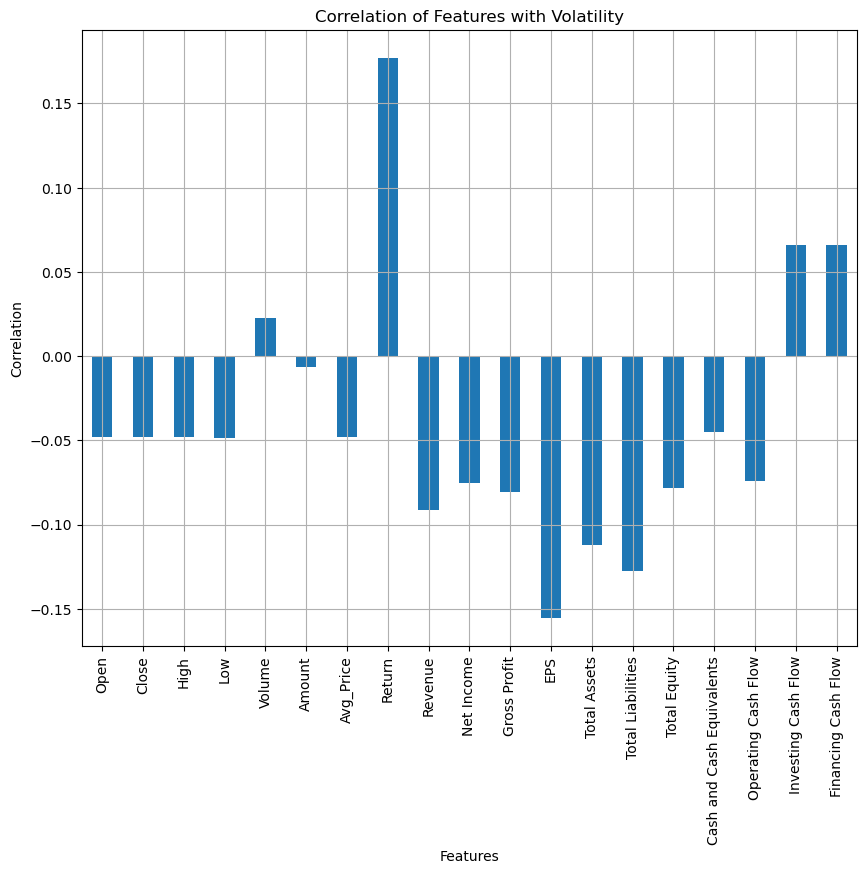

In [77]:
stock_no_resp = data.drop(columns= ['Volatility', 'Date', 'Stock'])
correlation = stock_no_resp.corrwith(data['Volatility'])

# Plot the correlation with a title
plt.figure(figsize=(10, 8))
correlation.plot.bar(grid=True)
plt.title('Correlation of Features with Volatility')  
plt.xlabel('Features')  
plt.ylabel('Correlation')  
plt.show()

<b>Exploratory Analysis:</b>

The correlation analysis shows that Return has the strongest positive correlation with volatility, suggesting higher returns are linked to increased volatility and vice versa. Financing Cash Flow and Investing Cash Flow also correlate positively. Conversely, financial stability metrics like Revenue, Net Income, and Total Assets have negative correlations, indicating more financially stable companies tend to be less volatile.


----

### Feature Engineering

- Interaction Features
<b>Volume_Price_Interaction:</b> Multiplies Volume and Return to capture the combined effect of trading activity and price movement on volatility.
<b>Price_Range:</b> Measures the percentage difference between the highest and lowest prices relative to the opening price, indicating daily price variability.

- Lagged Features
<b>Volatility_Lag1</b> and <b>Return_Lag1:</b> Capture the previous period's Volatility and Return.

- Rolling Statistics
<b>Volatility Rolling Mean</b> and <b>Volatility Standard Deviation:</b> Calculated over a 3-period window to capture short-term trends and variability in volatility.

- Technical Indicators
<b>Simple Moving Average (SMA):</b> A 5-period SMA of Volatility to smooth short-term fluctuations and highlight longer-term trends.


### Data Splitting Strategy
The data was split into training and validation sets using a time-based approach to ensure the model captures temporal dependencies accurately:
- <b>Training Set:</b> For each stock, the training set consists of all observations except the last 4 periods (first 18 months). This allows the model to learn from a substantial historical range, capturing long-term patterns and trends in the data.
- <b>Validation Set:</b> The validation set includes the last 4 observations for each stock (19th to 22nd month). This simulates a realistic forecasting scenario, where the model's performance is tested on the most recent data that was not used during training.


----

In [6]:
stock_df = data.copy()

In [7]:
# Extract features from Date
stock_df['Year'] = stock_df['Date'].dt.year
stock_df['Month'] = stock_df['Date'].dt.month
stock_df['DayOfWeek'] = stock_df['Date'].dt.dayofweek

stock_df = stock_df.drop('Date', axis=1)

In [8]:
# Feature Engineering
stock_df['Volume_Price_Interaction'] = stock_df['Volume'] * stock_df['Return']
stock_df['Price_Range'] = (stock_df['High'] - stock_df['Low']) / stock_df['Open'] * 100
stock_df['Volatility_Next'] = stock_df.groupby('Stock')['Volatility'].shift(-1)

# Lagged features
stock_df['Volatility_Lag1'] = stock_df.groupby('Stock')['Volatility'].shift(1)
stock_df['Return_Lag1'] = stock_df.groupby('Stock')['Return'].shift(1)

# Rolling statistics: 3-period rolling mean and standard deviation for 'Volatility'
stock_df['Volatility_RollingMean'] = stock_df.groupby('Stock')['Volatility'].transform(lambda x: x.rolling(window=3).mean())
stock_df['Volatility_RollingStd'] = stock_df.groupby('Stock')['Volatility'].transform(lambda x: x.rolling(window=3).std())

# Example: Add technical indicators (e.g., moving averages)
stock_df['SMA_5'] = stock_df.groupby('Stock')['Volatility'].transform(lambda x: x.rolling(window=5).mean())

# Drop rows with NaN values resulting from lag and rolling operations
stock_df = stock_df.dropna()

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler

num_features = ['Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price',
       'Return', 'Revenue', 'Net Income', 'Gross Profit', 'EPS',
       'Total Assets', 'Total Liabilities', 'Total Equity',
       'Cash and Cash Equivalents', 'Operating Cash Flow',
       'Investing Cash Flow', 'Financing Cash Flow',
       'Volume_Price_Interaction', 'Volatility_Lag1',
       'Return_Lag1', 'Volatility_RollingMean', 'Volatility_RollingStd',
       'SMA_5']

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the numerical features
stock_df[num_features] = scaler.fit_transform(stock_df[num_features])

In [10]:
# Select features and target
features = ['Volatility_RollingMean', 'SMA_5', 'Volatility_Lag1',
            'Volatility_RollingStd', 'Return', 'DayOfWeek', 'Volume_Price_Interaction',
            'Volume', 'Return_Lag1', 'Price_Range', 'Month']
target = 'Volatility_Next'

In [11]:
# Split the data into training and validation sets (18 months training, last 4 months for valadation set)
train_set = stock_df.groupby('Stock').apply(lambda x: x.iloc[:-4]).reset_index(drop=True)
validation_set = stock_df.groupby('Stock').apply(lambda x: x.iloc[-4:]).reset_index(drop=True)

/var/folders/8v/_f0s3ppn27g2ss5m_lvb311m0000gn/T/ipykernel_2286/1851419804.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_set = stock_df.groupby('Stock').apply(lambda x: x.iloc[:-4]).reset_index(drop=True)
/var/folders/8v/_f0s3ppn27g2ss5m_lvb311m0000gn/T/ipykernel_2286/1851419804.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validation_set = stock_df.groupby('Stock').apply(lambda x: x.iloc[

In [12]:
# Separate features and target for training and testing
X_train = train_set[features]
y_train = train_set[target]
X_test = validation_set[features]
y_test = validation_set[target]

----- 
# Lasso Regression

In [13]:
# Define Lasso model and hyperparameter grid
lasso = Lasso(random_state=1)
param_distributions = {
    'alpha': uniform(0.0001, 1.0)  # Regularization strength
}

# Use RandomizedSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scorer = make_scorer(root_mean_squared_error)

random_search = RandomizedSearchCV(estimator=lasso, param_distributions=param_distributions,
                                   scoring=rmse_scorer, cv=tscv, n_jobs=-1, n_iter=20, random_state=1)

# Fit the model
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Lasso(random_state=1), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1775cf740>},
                   random_state=1,
                   scoring=make_scorer(root_mean_squared_error, response_method='predict'))

In [14]:
# Best Lasso model
best_lasso = random_search.best_estimator_
print(f"Best Lasso RMSE: {random_search.best_score_:.4f}")
print(f"Best Lasso Params: {random_search.best_params_}")

Best Lasso RMSE: 1.8588
Best Lasso Params: {'alpha': 0.5389167340033569}


In [15]:
# Predict the next month's volatility using the best Lasso model
lasso_pred_23 = best_lasso.predict(X_test)

# Compile predictions into a DataFrame
lasso_pd_23 = pd.DataFrame({
    'Stock': validation_set['Stock'],
    'Volatility_Predicted': lasso_pred_23
})

# Evaluate the model's performance
final_rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_pred_23))
rmse_results['Lasso'] = final_rmse_lasso
print(f"Final RMSE on Validation Set (Lasso): {final_rmse_lasso:.4f}")

lasso_pd_23.head()

Final RMSE on Validation Set (Lasso): 1.1988


,Stock,Volatility_Predicted
0,A,1.767358
1,A,2.009081
2,A,1.921424
3,A,2.012784
4,AAL,2.509373


                    Feature  Coefficient  Importance
9               Price_Range     0.060848    0.060848
2           Volatility_Lag1     0.010774    0.010774
6  Volume_Price_Interaction    -0.000224    0.000224
0    Volatility_RollingMean     0.000000    0.000000
1                     SMA_5     0.000000    0.000000


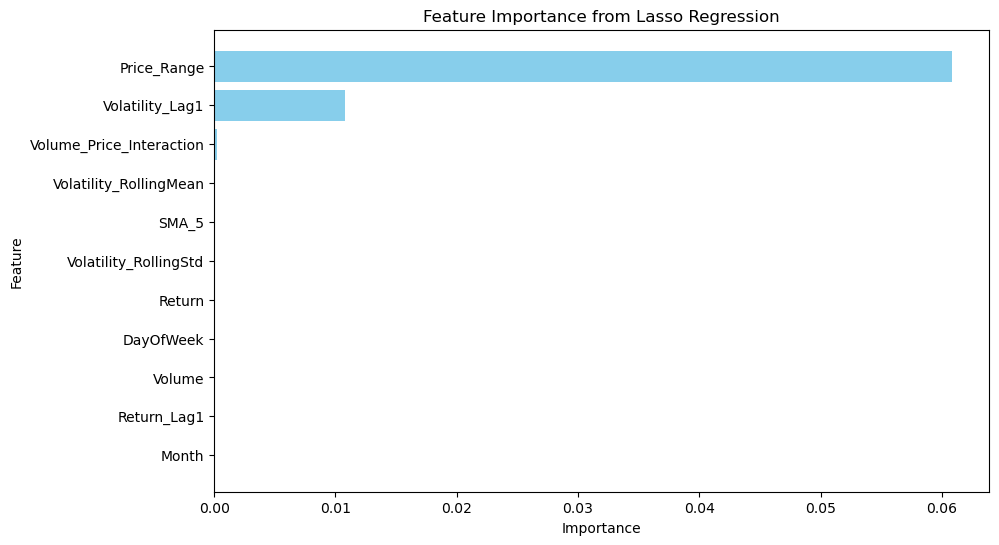

In [16]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]
lasso_coefficients = best_lasso.coef_

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients
})

feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance.head())

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

# ----
# Randomforest

In [17]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

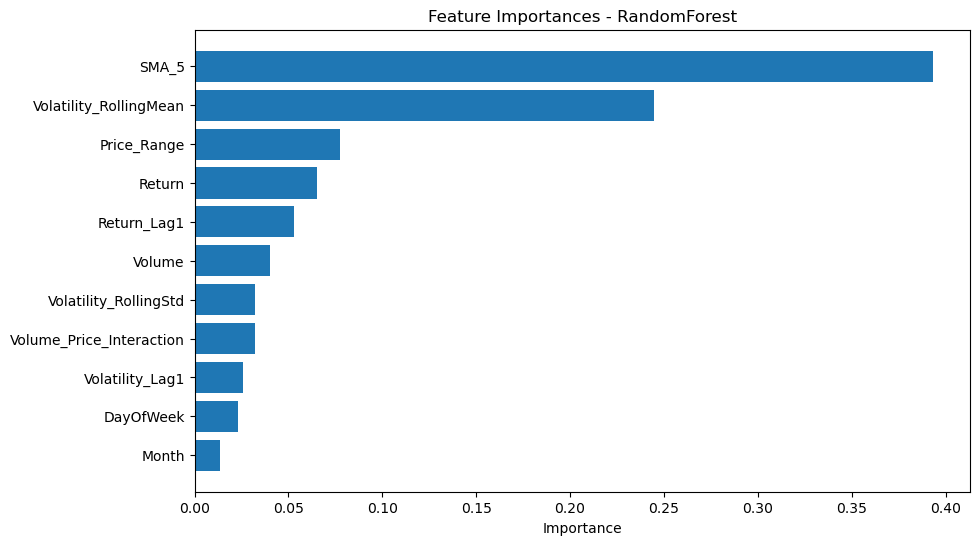

In [18]:
import matplotlib.pyplot as plt
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_names = X_train.columns  # Assuming X_train is a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances - RandomForest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

# Tuning Hyperparameter (RF)

In [43]:
param_distributions_rf = {
        'n_estimators': randint(50, 200),
        'max_depth': randint(10, 30),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4),
        'max_features': ['sqrt', 'log2']
    }

In [20]:
param_grid = {
    'n_estimators': [50],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap' : [True],
    'n_jobs': [-1],
    'random_state': [1],
    'max_features': ['sqrt']
}

In [21]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(root_mean_squared_error)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions_rf, 
                                   scoring=rmse_scorer, cv=tscv, n_jobs=-1, random_state=1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177428aa0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17778cd10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17717a930>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1772bf680>},
                   random_state=1,
                   scoring=make_scorer(root_mean_squared_error, response_method='predict'))

In [23]:
# Best RF model
best_rf = random_search.best_estimator_
print(f"Best RF RMSE: {random_search.best_score_:.4f}")
print(f"Best RF Params: {random_search.best_params_}")

Best RF RMSE: 1.6166
Best RF Params: {'max_depth': 21, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 179}


In [24]:
rf_pred = best_rf.predict(X_test)

rf_pd = pd.DataFrame({
    'Stock': validation_set['Stock'],
    'Volatility' : y_test,
    'Volatility_P': rf_pred
})


final_rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
rmse_results['RandomForest'] = final_rmse_rf
print("RMSE (RandomForest):", final_rmse_rf)

RMSE (RandomForest): 0.9755691985502853


In [25]:
rf_pd

,Stock,Volatility,Volatility_P
0,A,1.370561,1.622095
1,A,1.412848,1.532658
2,A,1.251545,1.349646
3,A,1.613197,1.434359
4,AAL,1.848423,1.822277
...,...,...,...
2447,ZUMZ,2.751268,2.902350
2448,ZUO,3.361847,3.265452
2449,ZUO,3.262500,3.308439
2450,ZUO,1.890770,2.775170


# ----
# Gradient Boosting Machine

In [26]:
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5)

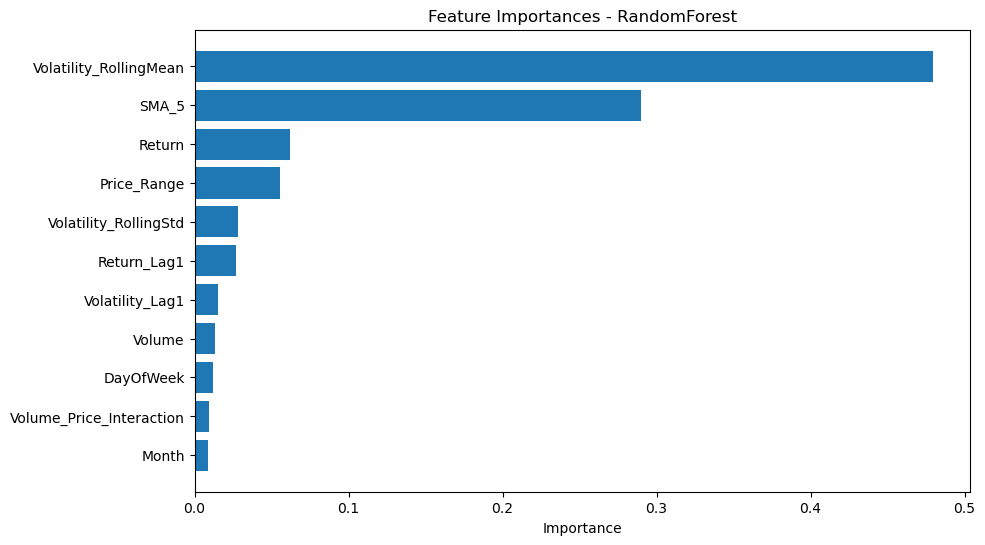

In [27]:
# Get feature importances
importances = gbm_model.feature_importances_

# Create a DataFrame for better visualization
feature_names = X_train.columns  # Assuming X_train is a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances - RandomForest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

In [28]:
param_distributions = {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.1),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10)
}

In [29]:
# Use RandomizedSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scorer = make_scorer(root_mean_squared_error)

random_search = RandomizedSearchCV(estimator=gbm_model, param_distributions=param_distributions,
                                   scoring=rmse_scorer, cv=tscv, n_jobs=-1, n_iter=20, random_state=1)

# Fit the model
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=GradientBoostingRegressor(max_depth=5), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1771471a0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177196c60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1772806e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1771470e0>},
                   random_state=1,
                   scoring=make_scorer(root_mean_squared_error, response_method='predict'))

In [30]:
# Best GBM model
best_gbm = random_search.best_estimator_
print(f"Best GBM RMSE: {random_search.best_score_:.4f}")
print(f"Best GBM Params: {random_search.best_params_}")

Best GBM RMSE: 1.6943
Best GBM Params: {'learning_rate': 0.020322600657764204, 'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 59}


In [31]:
gbm_pred = best_gbm.predict(X_test)

gbm_pd = pd.DataFrame({
    'Stock': validation_set['Stock'],
    'Volatility' : y_test,
    'Volatility_P': gbm_pred
})


final_rmse_gbm = np.sqrt(mean_squared_error(y_test, gbm_pred))
rmse_results['GradientBoosting'] = final_rmse_gbm
print("RMSE (GradientBoosting):", final_rmse_gbm)

RMSE (GradientBoosting): 1.0622555024699332


In [32]:
gbm_pd.head()

,Stock,Volatility,Volatility_P
0,A,1.370561,1.784725
1,A,1.412848,1.771173
2,A,1.251545,1.697920
3,A,1.613197,1.659014
4,AAL,1.848423,1.997554


----
## Forecast 23rd month

### Target Variable

The target variable is <b>Volatility_Next</b>, which represents the next month's volatility, effectively shifting the original Volatility data by one period. This shift allows the model to forecast the 23rd month's volatility for each stock based on preceding data. Since the 23rd month does not exist in the validation set, this approach ensures the model is trained to predict the next unseen period accurately.

### Model Selection
To predict stock volatility, three models were considered: Lasso Regression, Random Forest, and Gradient Boosting.
- Lasso Regression: Chosen for its simplicity and ability to perform feature selection through regularization.
- Random Forest Regressor: Selected for its robustness to outliers and ability to handle non-linear relationships and feature interactions. 
- Gradient Boosting Regressor: Included for its strength in modelling complex relationships through iterative refinement, minimizing errors from previous iterations. 

Each model was tuned using RandomizedSearchCV with Time Series Cross-Validation to appropriately handle temporal data dependencies. Time Series Cross-Validation (TimeSeriesSplit) with 5 splits was employed to maintain the temporal order of the data and prevent data leakage. The final model selection was based on RMSE.

### Hyperparameter Tuning:
- Lasso Regression: {'alpha': 0.5389167340033569}, with a final RMSE of 1.1988.
- Random Forest: {'max_depth': 21, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 179}, with a final RMSE of 0.9755.
- Gradient Boosting: {'learning_rate': 0.0203, 'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 59}, with a final RMSE of 1.0622.

| Model              | RMSE   |
|--------------------|--------|
| Lasso Regression   | 1.1988 |
| Random Forest      | 0.9755 |
| Gradient Boosting  | 1.0622 |

### Best Model Selection:
- The Random Forest was selected as the best model due to its superior performance, demonstrating robustness to outliers and the ability to handle diverse feature importance effectively.

### Feature Importance Analysis
|Feature	|Importance |
|-----------|-----------|
|SMA_5|0.360099|
|Volatility_RollingMean|0.274681|
|Price_Range|0.092931|
|Return|0.070345|
|Return_Lag1|0.041287|

Top five importance features

The final feature set was selected based on their effectiveness in capturing temporal trends, market dynamics, and variability, as identified through feature importance analysis. Key features include:
- Volatility_RollingMean and SMA_5: These features provide insights into recent trends and long-term smoothing, capturing both short-term volatility changes and overall stability.
- Price_Range: Reflects intra-day variability, highlighting the extent of price fluctuations within each day.
- Volatility_Lag1 and Return_Lag1: These lagged features account for historical effects, leveraging past volatility and returns to improve predictive accuracy.
- Return: Directly relates to volatility, making it a crucial feature for capturing the primary drivers of stock price movements.
- Volume_Price_Interaction and Volume: Offer insights into trading activity, linking price movements with trading volume to understand market behaviour.
- DayOfWeek and Month: Capture cyclic patterns that reflect seasonal and weekly trends in stock performance.


In [33]:
stock_df = data.copy()

In [34]:
# Extract features from Date
stock_df['Year'] = stock_df['Date'].dt.year
stock_df['Month'] = stock_df['Date'].dt.month
stock_df['DayOfWeek'] = stock_df['Date'].dt.dayofweek

stock_df = stock_df.drop('Date', axis=1)

In [35]:
# Feature Engineering
stock_df['Volume_Price_Interaction'] = stock_df['Volume'] * stock_df['Return']
stock_df['Price_Range'] = (stock_df['High'] - stock_df['Low']) / stock_df['Open'] * 100

# Lagged features
stock_df['Volatility_Lag1'] = stock_df.groupby('Stock')['Volatility'].shift(1)
stock_df['Return_Lag1'] = stock_df.groupby('Stock')['Return'].shift(1)

# Rolling statistics: 3-period rolling mean and standard deviation for 'Volatility'
stock_df['Volatility_RollingMean'] = stock_df.groupby('Stock')['Volatility'].transform(lambda x: x.rolling(window=3).mean())
stock_df['Volatility_RollingStd'] = stock_df.groupby('Stock')['Volatility'].transform(lambda x: x.rolling(window=3).std())

# Example: Add technical indicators (e.g., moving averages)
stock_df['SMA_5'] = stock_df.groupby('Stock')['Volatility'].transform(lambda x: x.rolling(window=5).mean())

# Drop rows with NaN values resulting from lag and rolling operations
stock_df = stock_df.dropna()

stock_df['Volatility_Next'] = stock_df.groupby('Stock')['Volatility'].shift(-1)

In [36]:
from sklearn.preprocessing import StandardScaler, RobustScaler

num_features = ['Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price',
       'Return', 'Revenue', 'Net Income', 'Gross Profit', 'EPS',
       'Total Assets', 'Total Liabilities', 'Total Equity',
       'Cash and Cash Equivalents', 'Operating Cash Flow',
       'Investing Cash Flow', 'Financing Cash Flow',
       'Volume_Price_Interaction', 'Volatility_Lag1',
       'Return_Lag1', 'Volatility_RollingMean', 'Volatility_RollingStd',
       'SMA_5']

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the numerical features
stock_df[num_features] = scaler.fit_transform(stock_df[num_features])

In [37]:
stock_forecast = stock_df.copy()

In [38]:
# Split the data into training and validation sets (21 months training, 22rd month for valadation set)
train_set = stock_forecast.groupby('Stock').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
test_set = stock_forecast.groupby('Stock').apply(lambda x: x.iloc[-1:]).reset_index(drop=True)

/var/folders/8v/_f0s3ppn27g2ss5m_lvb311m0000gn/T/ipykernel_2286/3687266219.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_set = stock_forecast.groupby('Stock').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
/var/folders/8v/_f0s3ppn27g2ss5m_lvb311m0000gn/T/ipykernel_2286/3687266219.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_set = stock_forecast.groupby('Stock').apply(lambda x: x

In [39]:
# Select features and target
features = ['Volatility_RollingMean', 'SMA_5', 'Volatility_Lag1',
            'Volatility_RollingStd', 'Return', 'DayOfWeek', 'Volume_Price_Interaction',
            'Volume', 'Return_Lag1', 'Price_Range', 'Month']
target = 'Volatility_Next'

In [40]:
# Separate features and target for training and testing
X_train = train_set[features]
y_train = train_set[target]
X_test = test_set[features]
y_test = test_set[target]

In [41]:
rf_model = RandomForestRegressor(n_estimators=113, max_depth=23, min_samples_split=9, max_features='log2', min_samples_leaf= 2)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, max_features='log2', min_samples_leaf=2,
                      min_samples_split=9, n_estimators=113)

In [44]:
# Use RandomizedSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scorer = make_scorer(root_mean_squared_error)

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions_rf, 
                                   scoring=rmse_scorer, cv=tscv, n_jobs=-1, n_iter=20, random_state=1)

# Fit the model on the training set
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(max_depth=23,
                                                   max_features='log2',
                                                   min_samples_leaf=2,
                                                   min_samples_split=9,
                                                   n_estimators=113),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x312e74260>,
                                        'max_featu...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x312e74770>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x312e77aa0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x312e760f0>},
                   random_state=1,
                   scoring=make_scorer(root_mean_squared_error, response_method='predict'))

In [46]:
rf_pred_23 = random_search.predict(X_test)

rf_pd_23 = pd.DataFrame({
    'Stock': test_set['Stock'],
    'Volatility': rf_pred_23
})

rf_pd_23

,Stock,Volatility
0,A,1.941422
1,AAL,2.155556
2,ABG,2.677271
3,ABT,1.002089
4,ACA,1.774997
...,...,...
608,ZG,3.525365
609,ZS,3.488869
610,ZTO,1.470857
611,ZUMZ,3.410777


In [47]:
pd.DataFrame.to_csv(rf_pd_23, 'rf_ml.csv', index=False)

### Discussion
The results of the analysis indicate that the Random Forest model performed best among the tested models (Lasso Regression, Random Forest, and Gradient Boosting) in predicting stock volatility. The model effectively utilized features such as rolling means of volatility and simple moving averages, which were identified as the most important predictors, reflecting that recent trends and historical volatility patterns play crucial roles in predicting future volatility.

### Limitation
The approach to split the data by reserving the last four observations for validation means that the model was not directly tested on the exact future period of interest (the 23rd month). This could impact the generalizability of the predictions to unseen, longer-term horizons.

Although the selected features were carefully chosen, the model's performance might be further enhanced by incorporating additional external factors such as macroeconomic indicators or global market indices, which were not included in this analysis.

### Conclusion
This analysis predicted stock volatility using the Random Forest model, which outperformed Lasso Regression and Gradient Boosting by effectively capturing complex relationships and temporal patterns. Key features like rolling means and moving averages of volatility were crucial for accurate forecasting. The time-based data splitting and target shifting allowed realistic prediction scenarios, though the model's complexity and stability assumptions pose challenges in adapting to sudden market changes. The results highlight the value of combining domain knowledge, feature engineering, and ensemble modeling for financial forecasting. Future enhancements could include incorporating additional financial indicators or exploring advanced models, such as deep learning, to further improve predictive accuracy and adaptability in dynamic market conditions.

------- 
### **OPTIONAL**
----
#### predict 24th month

In [51]:
stock_forecast = stock_df.copy()

stock_forecast['Volatility_Next'] = stock_forecast.groupby('Stock')['Volatility'].shift(-2)

# Split the data into training and validation sets
train_set = stock_forecast.groupby('Stock').apply(lambda x: x.iloc[:-2]).reset_index(drop=True)
test_set = stock_forecast.groupby('Stock').apply(lambda x: x.iloc[-2:]).reset_index(drop=True)

# Select features and target
features = ['Volatility_RollingMean', 'SMA_5', 'Volatility_Lag1',
            'Volatility_RollingStd', 'Return', 'DayOfWeek', 'Volume_Price_Interaction',
            'Volume', 'Return_Lag1', 'Price_Range', 'Month']
target = 'Volatility_Next'

# Separate features and target for training and testing
X_train = train_set[features]
y_train = train_set[target]
X_test = test_set[features]
y_test = test_set[target]

rf_model = RandomForestRegressor(n_estimators=100, max_depth=5)
rf_model.fit(X_train, y_train)

rf_pred_24 = gbm_model.predict(X_test)

/var/folders/8v/_f0s3ppn27g2ss5m_lvb311m0000gn/T/ipykernel_2286/2070695192.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_set = stock_forecast.groupby('Stock').apply(lambda x: x.iloc[:-2]).reset_index(drop=True)
/var/folders/8v/_f0s3ppn27g2ss5m_lvb311m0000gn/T/ipykernel_2286/2070695192.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_set = stock_forecast.groupby('Stock').apply(lambda x: x

In [52]:
pred23_24 = pd.DataFrame(rf_pred_24)
pred23_24.columns = ['Volatility']
pred23_24['index']  = pred23_24.index // 2
pred23_24['P23'] = pred23_24[pred23_24.index %2 == 0]['Volatility']
pred23_24['P24'] = pred23_24[pred23_24.index %2 != 0]['Volatility']
pred23_24 = pred23_24.drop('Volatility', axis=1)
pred23_24 = pred23_24.drop('index', axis=1)
pred23 = pred23_24['P23'].dropna().reset_index(drop=True)
pred24 = pred23_24['P24'].dropna().reset_index(drop=True)

In [53]:
pred24

0      1.598692
1      1.812572
2      2.720403
3      0.995140
4      1.944423
         ...   
608    3.777016
609    3.339527
610    1.589458
611    3.875380
612    3.201048
Name: P24, Length: 613, dtype: float64

In [54]:
pd.DataFrame({
    'Stock': validation_set['Stock'],
    'Volatility_P23': pred23
})

,Stock,Volatility_P23
0,A,1.463395
1,A,1.664831
2,A,2.149483
3,A,0.891929
4,AAL,1.753082
...,...,...
2447,ZUMZ,NaN
2448,ZUO,NaN
2449,ZUO,NaN
2450,ZUO,NaN


In [55]:
pred_24_df = pd.DataFrame({
    'Stock': validation_set['Stock'],
    'Volatility_24th': pred24
})
pred_24_df

,Stock,Volatility_24th
0,A,1.598692
1,A,1.812572
2,A,2.720403
3,A,0.995140
4,AAL,1.944423
...,...,...
2447,ZUMZ,NaN
2448,ZUO,NaN
2449,ZUO,NaN
2450,ZUO,NaN


In [56]:
pd.DataFrame.to_csv(pred_24_df, 'pred_24.csv', index=False)

----
### Auto Regressive (AR)

In [57]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [58]:
stock_ar = data.copy()

In [59]:
# Get list of stock
stocks = stock_ar['Stock'].unique()

In [60]:
stock_ar_vol = stock_ar.groupby('Stock')['Volatility'].apply(list)

In [61]:
results = {}

# Loop through each stock and apply the AR model
for stock in stocks:
    # Filter data for the current stock
    stock_data = stock_ar[stock_ar['Stock'] == stock]

    train_ts = stock_data['Volatility'][:-1]
    test_ts = stock_data['Volatility'][-1:]

    # Fit an AR model
    ar_model = ARIMA(train_ts, order=(1,1,1)).fit()

    # Make predictions on the test set
    predictions_ar = ar_model.predict(start=len(train_ts), end=len(train_ts))

    # Evaluate the model using RMSE
    rmse = np.sqrt(mean_squared_error(test_ts, predictions_ar))

    # Store the results
    results[stock] = {}
    results[stock]['RMSE'] = rmse
    results[stock]['Predictions'] = predictions_ar.values[0]
    results[stock]['Actual'] = test_ts.values[0]

/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An

In [62]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.head()

,RMSE,Predictions,Actual
A,0.249639,1.363558,1.613197
AAL,0.581560,1.378441,1.960000
ABG,0.417787,1.992340,2.410127
ABT,0.349334,0.878702,1.228036
ACA,0.586586,2.143964,1.557378


In [63]:
# Create empty lists to store predictions and actual values
predictions = []
actual = []
rmse = []

# Extract predictions and actual values from results for each stock
for stock in results_df.index:
    predictions.append(results_df.loc[stock, 'Predictions'])
    actual.append(results_df.loc[stock, 'Actual'])
    rmse.append(results_df.loc[stock, 'RMSE'])


# Calculate RMSE
print("Root Mean Squared Error (RMSE):", np.mean(rmse))

Root Mean Squared Error (RMSE): 0.6399806552542022


In [64]:
results_df

,RMSE,Predictions,Actual
A,0.249639,1.363558,1.613197
AAL,0.581560,1.378441,1.960000
ABG,0.417787,1.992340,2.410127
ABT,0.349334,0.878702,1.228036
ACA,0.586586,2.143964,1.557378
...,...,...,...
ZG,0.603913,2.109299,2.713211
ZS,0.564331,3.385838,2.821507
ZTO,0.632883,1.670030,1.037146
ZUMZ,0.329969,3.081236,2.751268


In [65]:
results = {}

# Loop through each stock and apply the AR model
for stock in stocks:
    # Filter data for the current stock
    stock_data = stock_ar[stock_ar['Stock'] == stock]

    train_ts = stock_data['Volatility']
    test_ts = stock_data['Volatility'][-1:]

    # Fit an AR model
    ar_model = ARIMA(train_ts, order=(1,1,1)).fit()

    # Make predictions on the test set
    predictions_ar = ar_model.predict(start=len(train_ts), end=len(train_ts))

    # Evaluate the model using RMSE
    rmse = np.sqrt(mean_squared_error(test_ts, predictions_ar))

    # Store the results
    results[stock] = {}
    results[stock]['RMSE'] = rmse
    results[stock]['Predictions'] = predictions_ar.values[0]
    results[stock]['Actual'] = test_ts.values[0]

/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An

In [67]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.describe()

,RMSE,Predictions,Actual
count,613.000000,613.000000,613.000000
mean,0.464644,2.099332,2.160607
std,0.662183,1.263586,1.460954
min,0.000413,0.150403,0.142286
25%,0.089401,1.295800,1.222802
50%,0.223032,1.782474,1.787082
75%,0.531795,2.516270,2.561442
max,5.684695,10.666065,11.999849


Text(0.5, 1.0, 'Comparison of Acutual and Prediction value')

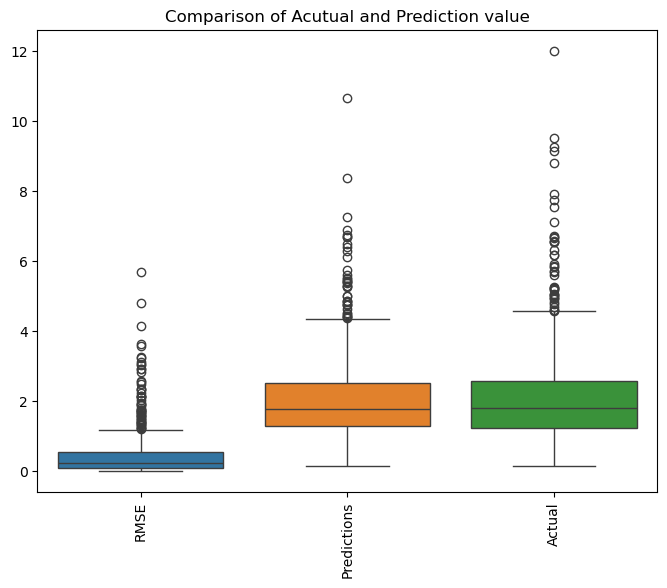

In [79]:
# Boxplot for outlier detection in key features
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df)
plt.xticks(rotation=90)
plt.title('Comparison of Acutual and Prediction value')